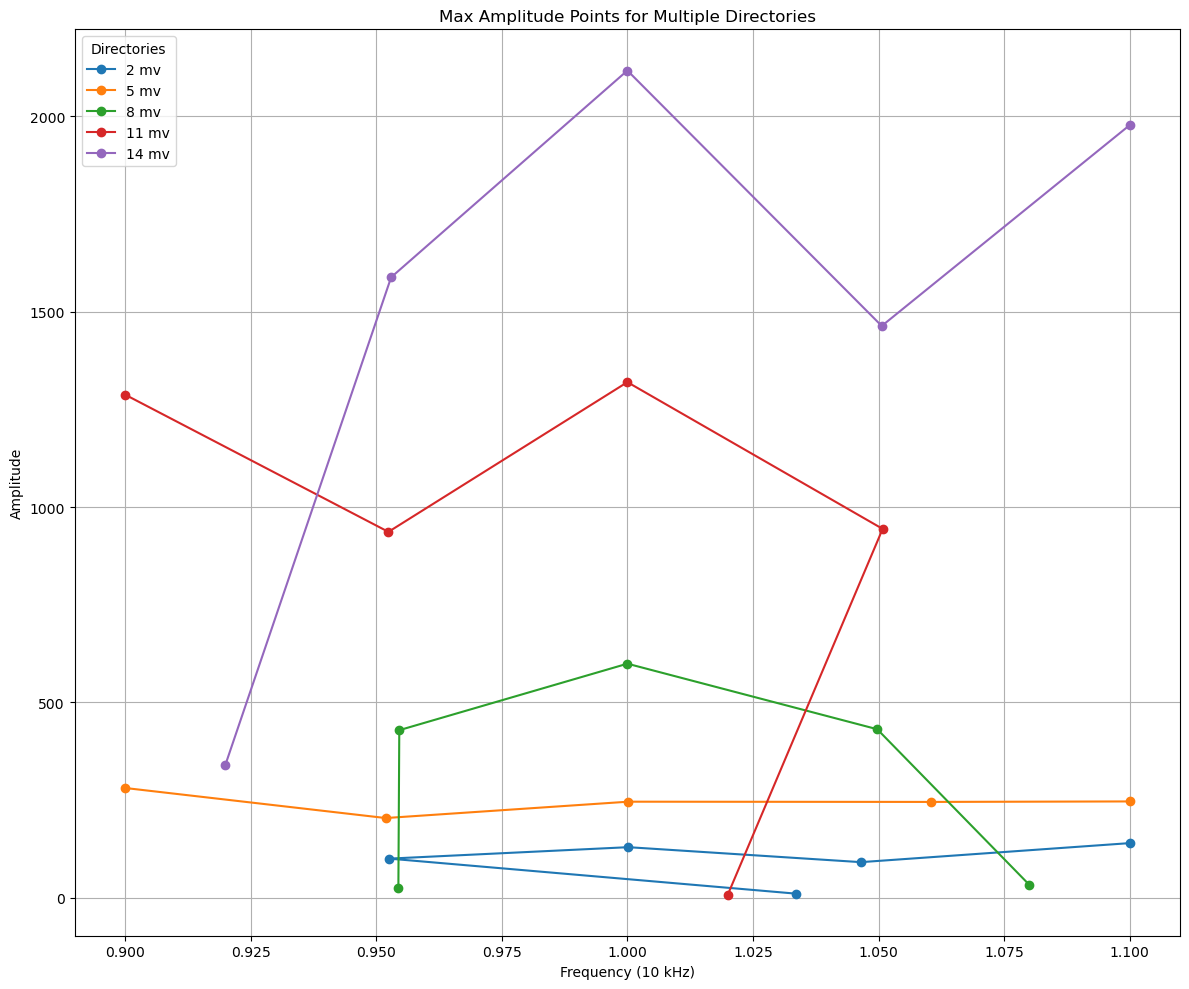

In [1]:
import glob
import os
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 주파수 범위 설정 (단위: Hz)
min_freq = 9000  # 최소 주파수 (9 kHz)
max_freq = 11000  # 최대 주파수 (11 kHz)

# 디렉토리 이름을 지정된 순서로 정렬
ordered_dirs = ['2 mv', '5 mv', '8 mv', '11 mv', '14 mv']

# 플롯 설정
plt.figure(figsize=(12, 10))

# 지정된 순서대로 각 서브 디렉토리에 대해 플롯 생성
for subdir in ordered_dirs:
    csv_files = glob.glob(os.path.join(subdir, "*.csv"))
    
    # 디렉토리에서 하나의 플롯에 대한 데이터 수집
    max_frequencies = []
    max_amplitudes = []
    
    for file in csv_files:
        data = pd.read_csv(file, skiprows=6)
        data.columns = ['Time', 'Voltage']
        data = data.dropna()

        time = data['Time'].values
        voltage = data['Voltage'].values

        n = len(time)
        dt = time[1] - time[0]
        frequencies = fftfreq(n, d=dt)
        fft_values = fft(voltage)

        positive_frequencies = frequencies[:n//2]
        positive_fft_values = np.abs(fft_values[:n//2])

        filtered_indices = (positive_frequencies >= min_freq) & (positive_frequencies <= max_freq)
        filtered_frequencies = positive_frequencies[filtered_indices]
        filtered_fft_values = positive_fft_values[filtered_indices]

        new_frequency_points = np.linspace(filtered_frequencies.min(), filtered_frequencies.max(), 1000)
        interpolator = interp1d(filtered_frequencies, filtered_fft_values, kind='cubic')
        new_fft_values = interpolator(new_frequency_points)

        max_amplitude_index = np.argmax(new_fft_values)
        max_frequency = new_frequency_points[max_amplitude_index] / 10000  # 주파수를 10 kHz 단위로 변환
        max_amplitude = new_fft_values[max_amplitude_index]

        # 최대 진폭 데이터를 리스트에 저장
        max_frequencies.append(max_frequency)
        max_amplitudes.append(max_amplitude)
    
    # 저장된 데이터로 플롯, 점과 점을 실선으로 연결
    plt.plot(max_frequencies, max_amplitudes, '-o', label=subdir)

# 플롯 설정
plt.title('Max Amplitude Points for Multiple Directories')
plt.xlabel('Frequency (10 kHz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend(title='Directories', loc='best')
plt.tight_layout()
plt.show()
